# Neural Network - Sonar Data - Stand-alone Spark Environment

Overview: Data set [description](http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)

Predictors are attributes named `X1` through `X60`.  Response variable is `target`.

Objective: develop feed-forward neural network to predict the `target`.

Algorithm: [MLPClassifer](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=MLPClassifier)

sklearn neural network [user guide](http://scikit-learn.org/stable/modules/neural_networks_supervised.html)


In [1]:
print("Spark Version: {}\n".format(sc.version))

Spark Version: 2.3.2



In [2]:
# Force more logging
sc.setLogLevel('INFO')

In [3]:
import numpy as np
import pandas as pd
import os
import sys
import socket

In [4]:
print("Python version: {}\n".format(sys.version))
print("Driver Programming running on host: {}\n".format(socket.gethostname()))
print ("OS: {}".format(os.uname()))

Python version: 3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0]

Driver Programming running on host: 85aba6502a4f

OS: posix.uname_result(sysname='Linux', nodename='85aba6502a4f', release='4.9.93-linuxkit-aufs', version='#1 SMP Wed Jun 6 16:55:56 UTC 2018', machine='x86_64')


## Read in raw data

In [5]:
#
# read in csv file
#
raw = pd.read_csv('./sonar.csv')
raw.shape

(208, 61)

In [6]:
# display sample
raw.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X52,X53,X54,X55,X56,X57,X58,X59,X60,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## Create train/test data sets

In [7]:
#
# create dataframe containing only predictors X1 through X60
#

# generate predictor names
predictors = ['X'+str(n) for n in range(1,61)]

print('first 5 predictors:', predictors[:5])
print('\nlast 5 predictors:',predictors[-5:])

first 5 predictors: ['X1', 'X2', 'X3', 'X4', 'X5']

last 5 predictors: ['X56', 'X57', 'X58', 'X59', 'X60']


In [8]:
# create data frame
raw_X = raw.loc[:,predictors]
raw_X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094


In [9]:
#
# translate response attribute from 'M'/'R' to 1/0
#
raw_y = raw.target.map(dict(M=1,R=0))
raw_y.value_counts()/raw_y.count()

1    0.533654
0    0.466346
Name: target, dtype: float64

In [10]:
from sklearn.model_selection import train_test_split
#
# 70%/30% split train/test data set
# set random seed for repeatability
#
train_X, test_X, train_y, test_y = train_test_split(raw_X, raw_y, test_size=0.3, random_state=39)

In [11]:
print('training response attribute profile\n',train_y.value_counts()/train_y.count())

training response attribute profile
 1    0.531034
0    0.468966
Name: target, dtype: float64


In [12]:
print('test response attribute profile\n', test_y.value_counts()/test_y.count())

test response attribute profile
 1    0.539683
0    0.460317
Name: target, dtype: float64


## Train neural network model

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [14]:
#
# Standardizing the predictors
#

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# transform predictors into standardize form
ss_train_X = ss.fit_transform(train_X)


# transform test data into standardized form
ss_test_X = ss.transform(test_X)


## Define training function - each Spark worker will run this function for one neural network architecture specification

In [15]:
def train_model(nn_structure):
   # print hidden layer specification
    #print('\nhidden layer: {}'.format(nn_structure))
    
    # define neural network model
    nn = MLPClassifier(hidden_layer_sizes=nn_structure, max_iter=4000, random_state=31)
    
    # fit model
    nn.fit(ss_train_X, train_y)
    
    # test model
    test_accuracy = 100*accuracy_score(test_y,nn.predict(ss_test_X))
    #print('\taccuracy: {:.2f}%'.format(test_accuracy))
    
    # keep track of test results
    return dict(hidden_layer=nn_structure, test_accuracy=test_accuracy,
               hostname=socket.gethostname(),pid=os.getpid())

## Define alternative network architectures for testing on Spark Workers

In [16]:
# 
# define network alternatives
#
hidden_layers = [
    (10,), # 1 hidden layer, 10 nodes
    (20,), # 1 hidden layer, 20 nodes
    (50,), # 1 hidden layer, 50 nodes
    (100,), # 1 hidden layer, 100 nodes
    (25,25), # 2 hidden layers, 25 nodes/25 nodes
    (40,40), # 2 hidden layers, 40 nodes/40 nodes
    (50, 25), # 2 hidden layers, 50 nodes/25 nodes
    (25,25,25), # 3 hidden layers, 25 nodes/ 25 nodes/ 25 nodes
    (10,10,10), # 3 hidden layers, 10 nodes/ 10 nodes/ 10 nodes
    (25,25,25,25), # 4 hidden layers, 25 nodes/ 25 nodes/ 25 nodes/ 25 nodes
    (25,20,15,10,5,10,15,20,25),
    (5,5,5,5,5,5,5,5,5,5),
    (20,20),
    (15,15)
    ]

## Distribute work to the Spark worker tasks

In [17]:
# create Spark rdd of alternative NN aarchitecture
rdd_hls = sc.parallelize(hidden_layers)


# run model training on all the different neural network architectures
results = rdd_hls.map(train_model)

## Display results of model training

In [18]:
#
# convert test results into data frame
#
result_df = pd.DataFrame(results.collect())
result_df

,hidden_layer,hostname,pid,test_accuracy
0,"(10,)",85aba6502a4f,843,73.015873
1,"(20,)",85aba6502a4f,843,74.603175
2,"(50,)",85aba6502a4f,854,76.190476
3,"(100,)",85aba6502a4f,854,74.603175
4,"(25, 25)",85aba6502a4f,850,77.777778
5,"(40, 40)",85aba6502a4f,850,74.603175
6,"(50, 25)",85aba6502a4f,848,69.841270
7,"(25, 25, 25)",85aba6502a4f,848,76.190476
8,"(10, 10, 10)",85aba6502a4f,860,76.190476
9,"(25, 25, 25, 25)",85aba6502a4f,860,76.190476


Text(0.5,1,'Test Data Set Performance')

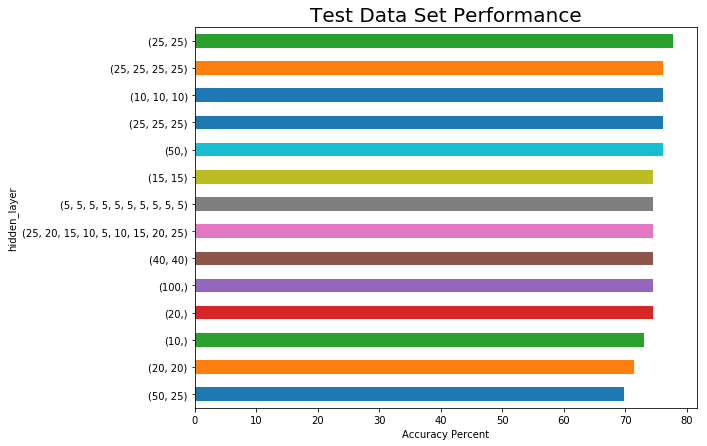

In [19]:
%matplotlib inline
#
# plot test data results
#
result_df.sort_values(['test_accuracy'],inplace=True)
ax = result_df.plot('hidden_layer','test_accuracy','barh',
                    figsize=(9,7),
                    legend=False)
ax.set_xlabel('Accuracy Percent')
ax.set_title('Test Data Set Performance',fontsize=20)